In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    N, M = A.shape
    B = tf.input([M, -1], tf.float32)
    K = B.shape[1]

    Bt = transpose(B)

    C = tf.zeros([N, K])
    i, j, k = tf.indices([N, K, M])
    tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])

    return [C]

mmul = tf.compile(matmul)

TensorFrost module loaded!
TensorProgram:
  Kernel count: 3
  Intermediate buffers: 5
  Lines of generated code: 137
  IR size: 82



In [3]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)

Cerror = np.linalg.norm(Cnp - Cnp2) / np.linalg.norm(Cnp2)
print("Error:", Cerror)


[[ 8.115925   9.018217   8.498305  ...  9.5552225 10.647078   8.421918 ]
 [ 8.363902   9.556349   8.723376  ...  9.713012  10.854008   8.826418 ]
 [ 7.2253046  7.6305404  8.297882  ...  8.948566   9.524342   7.5426407]
 ...
 [ 8.691064   7.826514   7.8910794 ...  8.570975   9.986826   8.277089 ]
 [ 6.776322   8.020783   7.640442  ...  8.135725   8.8330965  7.243946 ]
 [ 8.037988   8.686603   9.1378975 ...  8.803139   9.75271    7.6073923]]
[[ 8.115925   9.018218   8.498305  ...  9.555222  10.647079   8.421916 ]
 [ 8.363903   9.55635    8.723375  ...  9.713012  10.85401    8.82642  ]
 [ 7.2253036  7.630541   8.297882  ...  8.948566   9.524342   7.5426407]
 ...
 [ 8.691063   7.826514   7.891079  ...  8.570975   9.986824   8.27709  ]
 [ 6.7763214  8.020784   7.640442  ...  8.135726   8.833097   7.243946 ]
 [ 8.037989   8.686602   9.1378975 ...  8.80314    9.75271    7.6073914]]
Error: 6.690194e-08


In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 10)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 10)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.0010253256141962205
TensorFrost:  0.0529790202145854
TF/NP:  51.67043471952765


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.tensor(Anp)
    B = tf.tensor(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

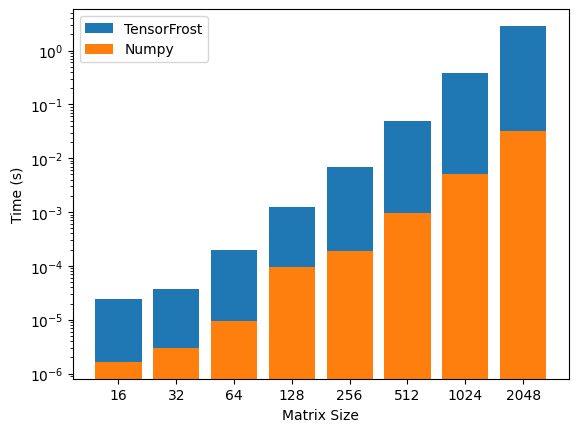

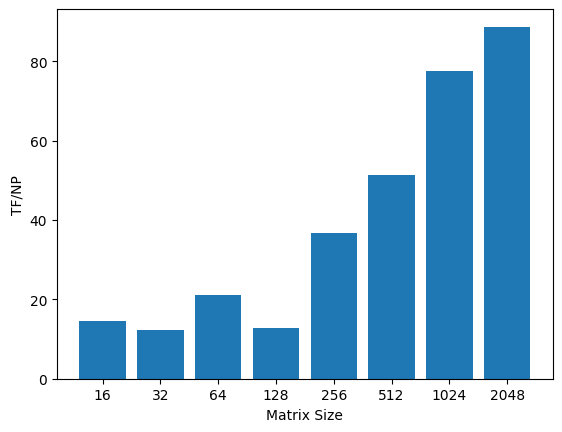

[2.3911310996942756e-05, 3.6471588292101384e-05, 0.00019708565075253378, 0.0012327555952400997, 0.006903451064537312, 0.04897663706824893, 0.3899997075398763, 2.8609864711761475]
[1.6462144390825584e-06, 2.998918682971188e-06, 9.37394072501964e-06, 9.673991262814726e-05, 0.00018826400020729224, 0.0009523818606422061, 0.005035181141378892, 0.03224998712539673]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)